In [25]:
import polars as pl
import os
from pathlib import Path
from polars.exceptions import ColumnNotFoundError

# Robustly locate the data file by searching the current working directory, parents, repo folders on common drives, and as a last resort drive-wide search
data_filename = 'sampledata_truthsocial.csv'
repo_name = 'cib-mango-tree-peter'

def find_data_file(data_filename, max_parent_levels=10):
    cwd = Path.cwd()
    tried = []
    # 1) Check cwd and its parents for data/<filename>
    for p in [cwd] + list(cwd.parents)[:max_parent_levels]:
        candidate = p / 'data' / data_filename
        tried.append(str(candidate))
        if candidate.exists():
            print(f"Found data file at {candidate} (from cwd parents)")
            return str(candidate)

    # 2) Look for repo_name in common drive roots (fast) and search under it
    for drive_letter in ['D:', 'C:', 'E:']:
        drive_root = Path(drive_letter + os.sep)
        if drive_root.exists():
            candidate_repo = drive_root / 'GitHub' / repo_name
            tried.append(str(candidate_repo))
            if candidate_repo.exists():
                try:
                    matches = list(candidate_repo.rglob(data_filename))
                    if matches:
                        print(f"Found data file under repo path {candidate_repo}")
                        return str(matches[0])
                except Exception:
                    pass

    # 3) Try to detect repo root by scanning cwd parents for .git/src/reports and then rglob under it
    for p in [cwd] + list(cwd.parents)[:max_parent_levels]:
        if (p / '.git').exists() or (p / 'src').exists() or (p / 'reports').exists():
            repo_root = p
            tried.append(str(repo_root))
            try:
                matches = list(repo_root.rglob(data_filename))
                if matches:
                    print(f"Found data file under detected repo root {repo_root}")
                    return str(matches[0])
            except Exception:
                pass

    # 4) As a last resort, attempt a drive-wide search on the current drive (may be slow; wrap in try/except)
    try:
        drive_root = Path(cwd.anchor)
        tried.append(str(drive_root))
        matches = list(drive_root.rglob(data_filename))
        if matches:
            print(f"Found data file via drive-wide search under {drive_root}")
            return str(matches[0])
    except Exception as e:
        # Don't raise; we'll show tried locations below
        print(f"Drive-wide search failed: {e}")

    print("Tried paths (first 20 shown):")
    for t in tried[:20]:
        print(" - ", t)
    return None

found_path = find_data_file(data_filename)
if found_path:
    data_file_path = found_path
else:
    # Last resort: keep original relative path (will raise meaningful FileNotFoundError)
    data_file_path = os.path.join('..', 'data', data_filename)
    print(f"Using fallback data path: {data_file_path}")

try:
    # Load the CSV file using polars
    df = pl.read_csv(data_file_path)

    # Display the first few rows to verify loading
    print("Data loaded successfully. First 5 rows:")
    print(df.head())

    # Display the data types of the columns
    print("\nData Types:")
    print(df.dtypes)

except FileNotFoundError:
    print(f"Error: Data file not found at {data_file_path}")
    print("Please ensure the filename is correct and the file exists in the 'data/' directory.")
except OSError as e:
    print(f"An OS error occurred while accessing the data file: {e}")
except Exception as e:
    print(f"An error occurred during data loading: {e}")

Found data file at D:\GitHub\cib-mango-tree-peter\data\sampledata_truthsocial.csv (from cwd parents)
Data loaded successfully. First 5 rows:
shape: (5, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ account.d ┆ account.u ┆ account.i ┆ content_c ┆ … ┆ in_reply_ ┆ reblog.id ┆ replies_c ┆ reblogs_ │
│ isplay_na ┆ sername   ┆ d         ┆ leaned    ┆   ┆ to_id     ┆ ---       ┆ ount      ┆ count    │
│ me        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│ ---       ┆ str       ┆ i64       ┆ str       ┆   ┆ f64       ┆           ┆ i64       ┆ i64      │
│ str       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ suzyQpatr ┆ suzyQpatr ┆ 107842819 ┆ RT @corte ┆ … ┆ null      ┆ 1.1390e17 ┆ 0         ┆ 0        │
│ iot       ┆ iot       ┆ 492508562 

## Step: Isolate and Prepare Post Timestamp (created_at) Column
**Why are we doing this?**

Focus: Our goal is time series analysis, specifically looking for patterns in when posts occur. The created_at column contains this crucial time information. Isolating it removes irrelevant data (like post content, usernames, etc.) for this specific analysis, making the process cleaner and more efficient. We rename it to post_timestamp simply for clarity and consistency with your proposal.




Correct Data Type: Computers need to understand that the values in this column represent points in time, not just sequences of characters (strings) or numbers. Time series analysis functions (like plotting over time, calculating autocorrelations, or aggregating by hour/day) require the data to be in a specific datetime format. If the data is currently a string (e.g., "2023-10-27 10:30:00") or a number (e.g., a Unix timestamp like 1698399000), we must convert it so the software can perform time-based calculations correctly.

**How does this affect the next step?**

Enables Time-Based Operations: Once the post_timestamp column is in the correct datetime format, we can perform essential time series operations. The very next step in your Week 1 plan is Initial Time-Series Diagnostics. This involves:


Visualization: Plotting the number of posts over time (e.g., posts per hour or day). This requires the datetime type to correctly order and space the data points on the time axis.


Aggregation: To perform burst detection or plot posts-per-hour, we need to group the data by time intervals (hour, minute, day). This aggregation relies heavily on the datetime data type.


ACF Calculation: Calculating the Autocorrelation Function (ACF) involves comparing the time series with lagged versions of itself. This inherently requires the data to be ordered correctly by time, which the datetime format ensures.




Foundation for Modeling: All subsequent analysis, including Burst Detection and Temporal Clustering (which involves extracting features like hour-of-day ), fundamentally depends on having accurate and usable timestamp data. Getting this step right is crucial for the validity of all future results.

In [26]:
try:
    # Load the CSV file using polars
    df = pl.read_csv(data_file_path)

    # --- Select and Prepare Timestamp ---
    ts_df = df.select(
        pl.col('created_at').alias('post_timestamp')
    )
    print("Original data type of post_timestamp:")
    print(ts_df.dtypes)

    if ts_df['post_timestamp'].dtype == pl.Utf8 or ts_df['post_timestamp'].dtype == pl.String:
        print("\nConverting string (ISO 8601 format) to datetime...")
        try:
            # Try Polars' fast parser first
            ts_df = ts_df.with_columns(
                pl.col('post_timestamp').str.to_datetime().alias('post_timestamp')
            )
            print("Automatic conversion successful!")
        except Exception as e:
            # Fall back to an eager, robust Python parsing approach using dateutil
            print(f"Automatic conversion failed ({e}). Falling back to Python parsing (dateutil)...")
            from dateutil import parser as _parser

            raw_values = ts_df['post_timestamp'].to_list()
            parsed = []
            for s in raw_values:
                if s is None or s == "":
                    parsed.append(None)
                    continue
                try:
                    parsed.append(_parser.isoparse(s))
                except Exception:
                    parsed.append(None)

            ts_df = ts_df.with_columns(
                pl.Series('post_timestamp', parsed).cast(pl.Datetime)
            )

        print("\nConverted data type:")
        print(ts_df.dtypes)
        print("\nNote: Timestamps are now in polars datetime[μs] (naive) which is compatible with subsequent aggregation.")


    # Display the first few rows with the prepared timestamp
    print("\nPrepared Timestamp Data:")
    print(ts_df.head())

except ColumnNotFoundError:
    print("Error: Column 'created_at' not found in the DataFrame.")
except Exception as e:
    print(f"An error occurred during conversion: {e}")

Original data type of post_timestamp:
[String]

Converting string (ISO 8601 format) to datetime...
Automatic conversion failed (`strptime` / `to_datetime` was called with no format and no time zone, but a time zone is part of the data.

This was previously allowed but led to unpredictable and erroneous results. Give a format string, set a time zone or perform the operation eagerly on a Series instead of on an Expr.). Falling back to Python parsing (dateutil)...

Converted data type:
[Datetime(time_unit='us', time_zone=None)]

Note: Timestamps are now in polars datetime[μs] (naive) which is compatible with subsequent aggregation.

Prepared Timestamp Data:
shape: (5, 1)
┌─────────────────────────┐
│ post_timestamp          │
│ ---                     │
│ datetime[μs]            │
╞═════════════════════════╡
│ 2025-01-27 05:04:04.797 │
│ 2025-01-27 05:07:12.056 │
│ 2025-01-27 05:07:16.126 │
│ 2025-01-27 05:07:45.702 │
│ 2025-01-27 05:12:06.137 │
└─────────────────────────┘


**1. Visualization**

**Why do this?** Plotting the data over time is the first step in understanding its behavior. We visually check for:

- Trends: Is the posting activity generally increasing or decreasing over time ?
- Seasonality: Are there repeating patterns within fixed time intervals (e.g., daily, weekly) ?
- Anomalies/Bursts: Are there obvious spikes or unusual periods of activity?
- Variance Stability: Does the amount of fluctuation change depending on the level of activity? (Needed for step 3)

**How does this affect the next step?** Visual inspection gives us initial clues about the data's structure. If we see strong seasonality or trends, it guides how we might approach modeling or transformation later. Obvious bursts might corroborate the findings of our burst detection algorithm.

In [27]:
import plotly.express as px
import polars as pl # Make sure polars is imported

if 'ts_df' not in locals():
    print("Error: ts_df not defined. Run the timestamp-prep cell first to create `ts_df`.")
else:
    try:
        # --- Ensure data is sorted by timestamp ---
        print("Sorting data by post_timestamp...")
        ts_df_sorted = ts_df.sort("post_timestamp")
        print("Sorting complete.")

        # --- Aggregate Data by Hour ---
        # Use the sorted DataFrame (ts_df_sorted) here
        print("Aggregating posts per hour...")
        posts_per_hour = ts_df_sorted.group_by_dynamic(
            index_column="post_timestamp",
            every="1h", # Aggregate into 1-hour bins
        ).agg(
            pl.len().alias('post_count') # Count posts in each bin
        ).sort("post_timestamp")
        print("Aggregation complete.")

        print("\nAggregated posts per hour (first 5 rows):")
        print(posts_per_hour.head())

        # --- Create Interactive Plot ---
        print("Creating plot...")
        fig = px.line(posts_per_hour.to_pandas(), # Plotly often works well with Pandas DataFrames
                      x='post_timestamp',
                      y='post_count',
                      title='Posts Per Hour on Truth Social Sample',
                      labels={'post_timestamp': 'Time', 'post_count': 'Number of Posts'})

        fig.show() # Display the plot in the notebook
        print("Plot displayed.")

    except Exception as e:
        print(f"An error occurred: {e}")

Sorting data by post_timestamp...
Sorting complete.
Aggregating posts per hour...
Aggregation complete.

Aggregated posts per hour (first 5 rows):
shape: (5, 2)
┌─────────────────────┬────────────┐
│ post_timestamp      ┆ post_count │
│ ---                 ┆ ---        │
│ datetime[μs]        ┆ u32        │
╞═════════════════════╪════════════╡
│ 2025-01-27 05:00:00 ┆ 64         │
│ 2025-01-27 06:00:00 ┆ 35         │
│ 2025-01-27 07:00:00 ┆ 13         │
│ 2025-01-27 08:00:00 ┆ 20         │
│ 2025-01-27 09:00:00 ┆ 29         │
└─────────────────────┴────────────┘
Creating plot...


Plot displayed.


Based on the plot ("Posts Per Hour on Truth Social Sample"):


- Trend: In this timeframe (approx. Jan 28 - Feb 15, 2025), there isn't a clear long-term increasing or decreasing trend . The overall level seems relatively stable, aside from fluctuations.

- Seasonality: There's a very strong, repeating pattern within each day (or possibly every 24 hours). Activity peaks and then drops significantly, suggesting daily seasonality . People likely post more during certain hours and less during others (e.g., overnight). There might be a weaker weekly pattern too, but the daily one dominates.

- Anomalies/Bursts: There is a particularly large spike in activity around February 13th. This peak is noticeably higher than the typical daily peaks, making it a candidate for a "burst"  that our burst detection algorithm might identify later. Other peaks around Jan 29/30 and Feb 4 also stand out, though less dramatically.


- Variance: The size of the fluctuations (variance) might be slightly larger during the periods of highest activity (like Feb 13th), which could suggest the variance isn't perfectly constant. We'll keep this in mind.

**2. Autocorrelation Function (ACF)**

**Why do this?** While our eyes see patterns, the Autocorrelation Function (ACF) provides a statistical measure of how correlated the time series is with lagged versions of itself . It helps us objectively confirm if the patterns we see are statistically significant or just random noise.


- onfirming Patterns: Significant correlations at specific lags confirm the presence of non-random patterns like seasonality or cycles. For example, strong daily seasonality should show high correlation at lags 24, 48, 72, etc. (hours).


- Checking for White Noise: If no lags (except lag 0) show significant correlation, the series might be "white noise" – purely random and unpredictable . Our plot clearly isn't white noise, but ACF confirms this statistically.


**How does this affect the next step?**


- Validation for Modeling: Confirming significant autocorrelation validates that the time series contains predictable patterns, making it suitable for modeling (like burst detection).

- Identifying Seasonality: The lags with significant spikes in the ACF plot pinpoint the period of seasonality (e.g., a spike at lag 24 confirms the 24-hour pattern). This is crucial information for later modeling steps, especially if we were to use seasonal models like SARIMA.


- Input for Order Selection: In later stages (beyond Week 1), the pattern of decay in the ACF helps in selecting appropriate orders for models like ARMA .

Calculating and plotting ACF...


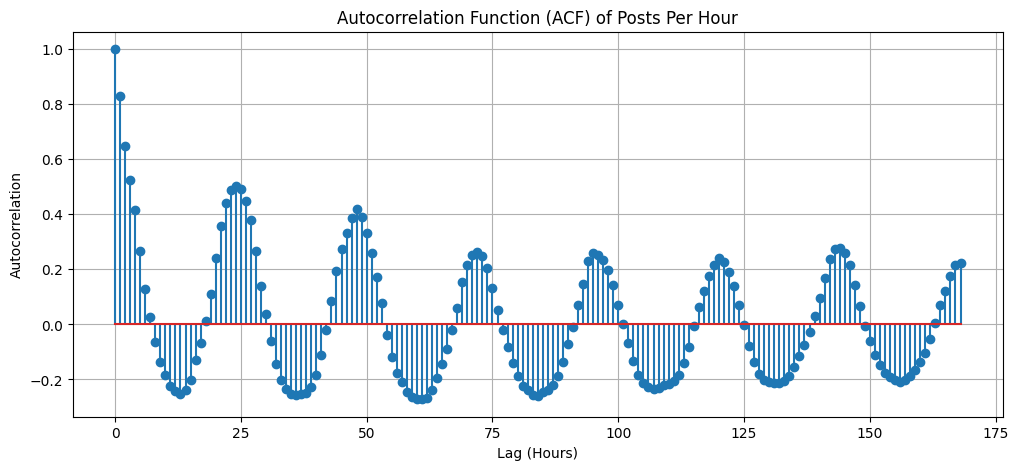

ACF plot displayed.


In [28]:
from statsmodels.tsa.stattools import acf as sm_acf
import matplotlib.pyplot as plt
import numpy as np

if 'posts_per_hour' not in locals():
    print("Error: posts_per_hour not defined. Run the aggregation cell first to create `posts_per_hour`.")
else:
    try:
        # --- Calculate and Plot ACF ---
        print("Calculating and plotting ACF...")

        # Determine a reasonable number of lags to check (e.g., a few days worth of hours)
        n_lags = 7 * 24 # Check correlations up to 7 days back

        fig, ax = plt.subplots(figsize=(12, 5)) # Create a plot figure

        # Ensure series is a 1-d numeric array / pandas Series
        series = posts_per_hour.to_pandas()['post_count'].dropna().astype(float)

        # Compute ACF values using statsmodels' acf function (robust across versions)
        acf_vals = sm_acf(series, nlags=n_lags, fft=True)
        lags = np.arange(len(acf_vals))

        ax.stem(lags, acf_vals)
        ax.set_title('Autocorrelation Function (ACF) of Posts Per Hour')
        ax.set_xlabel('Lag (Hours)')
        ax.set_ylabel('Autocorrelation')
        ax.grid(True)
        plt.show() # Display the plot
        print("ACF plot displayed.")

    except Exception as e:
        print(f"An error occurred during ACF calculation/plotting: {e}")

The ACF plot provides strong statistical confirmation of the patterns we saw in the previous visualization:

- Not White Noise: The plot shows many lags with correlation spikes far outside the blue confidence interval. This confirms the time series is not random noise and contains significant, predictable patterns.

- Strong Daily Seasonality: There are very prominent, significant positive spikes at lags 24, 48, 72, 96, 120, 144, and 168. This is a classic signature of a strong 24-hour (daily) seasonal pattern. It means the number of posts at any given hour is highly correlated with the number of posts 24 hours prior (and 48 hours prior, etc.).

- Within-Day Correlation: The lags between the daily spikes (e.g., lags 1-23) also show a pattern. The correlation starts high and positive (lag 1) and then dips, indicating that posting activity in one hour is also related to the activity in the immediately preceding and following hours.

In summary, the ACF plot confirms that the data has a strong, modelable 24-hour seasonal pattern, validating its suitability for time-series modeling.

**3. Transformation (Checking Variance)**
**Why do this?** This is the final diagnostic step for Week 1, as mentioned in your proposal. Many time-series models (and statistical tests) perform best when the variance of the data (the "spread" or "volatility") is constant over time (a property called homoscedasticity).

Our visual plot suggested that the variance might increase when the posting level increases (this is heteroscedasticity ). If this is the case, applying a mathematical transformation, such as a logarithm (log(y_t)), can help stabilize the variance, making the patterns cleaner and the model more reliable.



**How does this affect the next step?** If we find the variance is unstable, we should apply a log transformation to our post_count data. All subsequent analysis (like Burst Detection in Week 2) would then be performed on this transformed data (log(post_count)) rather than the raw counts. If the variance looks stable, we can proceed with the raw post_count data.

In [29]:
try:
    # --- Apply Log Transformation ---
    # We use log1p, which calculates log(1 + x), to avoid errors if post_count is 0
    posts_per_hour_transformed = posts_per_hour.with_columns(
        pl.col('post_count').log1p().alias('log_post_count')
    )

    print("Aggregated data with log transformation (first 5 rows):")
    print(posts_per_hour_transformed.head())

    # --- Create Comparison Plots ---

    # Plot 1: Original Data
    fig_original = px.line(posts_per_hour.to_pandas(),
                           x='post_timestamp',
                           y='post_count',
                           title='Original Posts Per Hour (Raw Count)')

    # Plot 2: Log-Transformed Data
    fig_log = px.line(posts_per_hour_transformed.to_pandas(),
                      x='post_timestamp',
                      y='log_post_count',
                      title='Log-Transformed Posts Per Hour (log(1 + Count))')

    print("Displaying plots for variance comparison...")
    fig_original.show()
    fig_log.show()
    print("Plots displayed.")

except Exception as e:
    print(f"An error occurred during transformation or plotting: {e}")

Aggregated data with log transformation (first 5 rows):
shape: (5, 3)
┌─────────────────────┬────────────┬────────────────┐
│ post_timestamp      ┆ post_count ┆ log_post_count │
│ ---                 ┆ ---        ┆ ---            │
│ datetime[μs]        ┆ u32        ┆ f64            │
╞═════════════════════╪════════════╪════════════════╡
│ 2025-01-27 05:00:00 ┆ 64         ┆ 4.174387       │
│ 2025-01-27 06:00:00 ┆ 35         ┆ 3.583519       │
│ 2025-01-27 07:00:00 ┆ 13         ┆ 2.639057       │
│ 2025-01-27 08:00:00 ┆ 20         ┆ 3.044522       │
│ 2025-01-27 09:00:00 ┆ 29         ┆ 3.401197       │
└─────────────────────┴────────────┴────────────────┘
Displaying plots for variance comparison...


Plots displayed.


**Analysis of Transformation**
- **Original Plot:** In the raw count data, the variance is unstable (heteroscedastic). The fluctuations during normal periods (e.g., Feb 5-10) are small (maybe 0-150), while the fluctuations during the major spike on Feb 13 are massive (from a low base to over 600). This difference in scale can skew the results of statistical models.


- **Log-Transformed Plot:** The log transformation has successfully stabilized the variance. The peaks and valleys now oscillate within a much more consistent range (roughly 2.5 to 6.0). The massive spike on Feb 13 is compressed and now looks proportional to the other large daily spikes (like the one on Jan 30), rather than exponentially larger.

**Decision and Next Steps**
This log-transformed data is much more suitable for the time-series modeling and statistical tests we plan to do, as it better meets the assumption of constant variance.

Therefore, for our Week 2 analysis (Burst Detection and Clustering), we will use the log_post_count column from the posts_per_hour_transformed DataFrame.

This completes all the tasks outlined for Week 1 of your proposal:

1. Setup & Data Exploration: Done.

2. Load Data: Done.

3. Perform Initial Time-Series Diagnostics:

    - Visualization: Done.

    - Autocorrelation (ACF): Done.

    - Transformation: Done.


## Week 2: Apply Burst Detection
**Why do this?** As outlined in your proposal, this is the core of "Methodology Prototyping (Burst Detection)". We're using Kleinberg's algorithm to identify anomalous "bursts" in posting activity. The pybursts library we just installed gives us a straightforward implementation of this algorithm.

**How does this affect the next step?** This analysis will produce a list of timestamps that the algorithm identifies as "bursting." This is the first major "Finding" from your data. This output will be directly used in Week 4 to create the interactive plotly visualization that highlights these specific bursts on the timeline, providing the "smoking gun" evidence your proposal mentions.

In [30]:
import numpy as np
import math
from typing import List, Tuple

# --- FIX for old library ---
# Manually re-create the deprecated 'np.float' alias
np.float = float
# ---------------------------

def kleinberg(offsets, s=2, gamma=1):

    if s <= 1:
       raise ValueError("s must be greater than 1!")
    if gamma <= 0:
       raise ValueError("gamma must be positive!")
    if len(offsets) < 1:
       raise ValueError("offsets must be non-empty!")

    offsets = np.array(offsets, dtype=object)

    if offsets.size == 1:
       bursts = np.array([0, offsets[0], offsets[0]], ndmin=2, dtype=object)
       return bursts

    offsets = np.sort(offsets)
    gaps = np.diff(offsets)

    if not np.all(gaps):
       print("Warning: Input contained events with zero time between!")
       gaps = gaps[gaps > 0] # Filter out zero gaps

    T = np.sum(gaps)
    n = np.size(gaps)
    g_hat = T / n

    k = int(math.ceil(float(1 + math.log(T, s) + math.log(1 / np.amin(gaps), s))))

    gamma_log_n = gamma * math.log(n)

    def tau(i, j):
       if i >= j:
          return 0
       else:
          return (j - i) * gamma_log_n

    alpha_function = np.vectorize(lambda x: s ** x / g_hat)
    alpha = alpha_function(np.arange(k))

    def f(j, x):
       return alpha[j] * math.exp(-alpha[j] * x)

    C = np.repeat(float("inf"), k)
    C[0] = 0

    q = np.empty((k, 0))
    for t in range(n):
       C_prime = np.repeat(float("inf"), k)
       q_prime = np.empty((k, t+1))
       q_prime.fill(np.nan)

       for j in range(k):
          cost_function = np.vectorize(lambda x: C[x] + tau(x, j))
          cost = cost_function(np.arange(0, k))

          el = np.argmin(cost)

          if f(j, gaps[t]) > 0:
             C_prime[j] = cost[el] - math.log(f(j, gaps[t]))

          if t > 0:
             q_prime[j,:t] = q[el,:]

          q_prime[j, t] = j + 1

       C = C_prime
       q = q_prime

    j = np.argmin(C)
    q = q[j,:]

    prev_q = 0

    N = 0
    for t in range(n):
       if q[t] > prev_q:
          N = N + q[t] - prev_q # N is a float
       prev_q = q[t]

    N = int(N) # <-- THIS IS THE FIX: Cast N to an integer

    bursts = np.array([np.repeat(np.nan, N), np.repeat(offsets[0],N),np.repeat(offsets[0], N)], ndmin=2, dtype=object).transpose()

    burst_counter = -1
    prev_q = 0

    stack = np.empty(N, dtype=int)

    stack_counter = -1
    for t in range(n):
       if q[t] > prev_q:
          num_levels_opened = q[t] - prev_q
          for i in range(int(num_levels_opened)):
             burst_counter += 1
             bursts[burst_counter, 0] = prev_q + i
             bursts[burst_counter, 1] = offsets[t]
             stack_counter += 1
             stack[stack_counter] = burst_counter
       elif q[t] < prev_q:
          num_levels_closed = prev_q - q[t]
          for i in range(int(num_levels_closed)):
             bursts[stack[stack_counter], 2] = offsets[t]
             stack_counter -= 1
       prev_q = q[t]

    while stack_counter >= 0:
       bursts[stack[stack_counter], 2] = offsets[n]
       stack_counter -= 1

    return bursts

In [31]:
import polars as pl
import pandas as pd
import datetime  # use datetime.timezone.utc

try:
    # --- Prepare Data for kleinberg function ---
    print("Preparing raw numeric timestamps...")
    raw_timestamps = (
        ts_df
        .sort('post_timestamp')
        .select(
            pl.col('post_timestamp').dt.epoch(time_unit="s").alias('unix_timestamp')
        )
        .unique()
        ['unix_timestamp']
        .to_list()
    )
    print(f"Prepared data for burst detection: {len(raw_timestamps)} unique timestamps.")

    # --- Run Kleinberg's Burst Detection Algorithm ---
    print("Running Kleinberg's algorithm...")
    bursts = kleinberg(raw_timestamps, s=2.0, gamma=1.0)
    print("Algorithm complete.")

    # --- Process the Results ---
    print("\n--- Detected Bursts (Level, Start, End) ---")
    print(bursts)

    posts_per_hour_with_bursts = posts_per_hour_transformed.with_columns(
        pl.lit(0).alias('burst_level')
    )

    burst_list = []

    for item in bursts:
        # Clean up data types from numpy array
        level = float(item[0])
        start_unix = int(item[1])
        end_unix = int(item[2])

        if level > 0:
            # Convert Unix int to naive UTC datetime compatible with Polars
            # Use fromtimestamp with explicit UTC and drop tzinfo to get naive UTC datetimes
            start_time = datetime.datetime.fromtimestamp(start_unix, tz=datetime.timezone.utc).replace(tzinfo=None)
            end_time = datetime.datetime.fromtimestamp(end_unix, tz=datetime.timezone.utc).replace(tzinfo=None)

            print(f"\n📈 Burst (Level {level}):")
            print(f"   From: {start_time} (Unix: {start_unix})")
            print(f"   To:   {end_time} (Unix: {end_unix})")

            burst_list.append({
                'level': level,
                'start_time': start_time, # This is now a datetime object (naive UTC)
                'end_time': end_time,     # This is now a datetime object (naive UTC)
            })

            # --- Update the AGGREGATED DataFrame for plotting ---
            cond_after_start = pl.col('post_timestamp') >= start_time
            cond_before_end = pl.col('post_timestamp') <= end_time

            posts_per_hour_with_bursts = posts_per_hour_with_bursts.with_columns(
                pl.when(cond_after_start & cond_before_end)
                  .then(pl.lit(level))
                  .otherwise(pl.col('burst_level'))
                  .alias('burst_level')
            )

    print("\n--- Summary of Bursts Found (as DataFrame) ---")
    print(pl.DataFrame(burst_list))

    print("\n--- Data with Burst Levels (for plotting) ---")
    print(posts_per_hour_with_bursts.filter(pl.col('burst_level') > 0).head())

except Exception as e:
    print(f"An error occurred during burst detection: {e}")

Preparing raw numeric timestamps...
Prepared data for burst detection: 46383 unique timestamps.
Running Kleinberg's algorithm...
Algorithm complete.

--- Detected Bursts (Level, Start, End) ---
[[0 1737954244 1739681907]
 [np.float64(1.0) 1737984904 1738002241]
 [np.float64(1.0) 1738007379 1738017507]
 [np.float64(1.0) 1738019960 1738025542]
 [np.float64(1.0) 1738034270 1738039052]
 [np.float64(1.0) 1738073650 1738074579]
 [np.float64(1.0) 1738077892 1738084719]
 [np.float64(2.0) 1738079449 1738079603]
 [np.float64(1.0) 1738109576 1738110508]
 [np.float64(1.0) 1738115421 1738115884]
 [np.float64(2.0) 1738115496 1738115865]
 [np.float64(1.0) 1738159217 1738208096]
 [np.float64(2.0) 1738164136 1738177844]
 [np.float64(2.0) 1738180422 1738182307]
 [np.float64(2.0) 1738199749 1738200863]
 [np.float64(1.0) 1738243694 1738253066]
 [np.float64(1.0) 1738257071 1738260944]
 [np.float64(1.0) 1738275145 1738277171]
 [np.float64(1.0) 1738287440 1738288184]
 [np.float64(1.0) 1738331810 1738337550]


## Visualize Burst Detection
**Why do this?** As your proposal states, this is the "smoking gun" deliverable for this part of the analysis. It translates the complex list of burst timestamps into a simple, interactive, human-readable report that allows a non-technical user to see the anomalous activity.



**How does this affect the next step?** This step creates the final output for our burst detection analysis. The posts_per_hour_with_bursts DataFrame, which we created specifically for this, has the burst_level column. We will use this column to color-code the plot, clearly highlighting the periods of anomalous activity. After this, the burst detection portion is complete, and we can move on to Week 3 with a clean slate.

In [32]:
import plotly.express as px

try:
    # --- Prepare for Plotting ---
    # We need to convert 'burst_level' to a string (categorical)
    # so Plotly treats it as distinct colors (0, 1, 2)
    # instead of a continuous number gradient.

    # Use the DataFrame we created in the last step
    plot_df = posts_per_hour_with_bursts.with_columns(
        pl.col('burst_level').cast(pl.String).alias('burst_category')
    )

    print("Creating interactive burst plot...")

    # --- Create Interactive Plot ---
    fig = px.line(
        plot_df.to_pandas(),
        x='post_timestamp',
        y='log_post_count',       # Plot the log-transformed data we analyzed
        color='burst_category',   # <-- This is the key part
        title='Burst Detection: Posts per Hour (Log Transformed)',
        labels={
            'log_post_count': 'Log(Posts per Hour)',
            'post_timestamp': 'Time',
            'burst_category': 'Burst Level'
        },
        markers=True # Add markers to make individual hours visible
    )

    fig.show() # Display the plot in the notebook
    print("Plot displayed.")

    # Optional: Save the plot as an HTML file
    # fig.write_html("burst_detection_plot.html")
    # print("\nPlot saved as burst_detection_plot.html")

except Exception as e:
    print(f"An error occurred during plotting: {e}")

Creating interactive burst plot...


Plot displayed.


In [33]:
import plotly.graph_objects as go
import polars as pl
import pandas as pd
import numpy as np

try:
    # --- Data We Need ---
    # We assume 'posts_per_hour_transformed' (a Polars DataFrame) and
    # 'burst_list' (a Python list of dicts) exist in the notebook's memory
    # from the previous cells.

    # We'll use the pandas-converted DataFrame for plotting
    plot_df = posts_per_hour_transformed.to_pandas()

    print("Creating cleaner, interactive burst plot with rectangles...")

    # --- Create the Base Figure ---
    fig = go.Figure()

    # --- 1. Add the Baseline Time Series Plot ---
    # This is the single, continuous line for the log_post_count
    fig.add_trace(
        go.Scatter(
            x=plot_df['post_timestamp'],
            y=plot_df['log_post_count'],
            mode='lines+markers',
            name='Log(Posts per Hour)',
            line=dict(color='blue'),
            marker=dict(size=4)
        )
    )

    # --- 2. Add Burst Rectangles ---

    # Define a color map for burst levels
    # We use 'rgba' to set the color and transparency (alpha)
    color_map = {
        1.0: 'rgba(255, 255, 0, 0.2)',  # Level 1: Transparent Yellow
        2.0: 'rgba(255, 165, 0, 0.3)',  # Level 2: Transparent Orange
        3.0: 'rgba(255, 0, 0, 0.4)'    # Level 3: Transparent Red
    }

    # Keep track of levels we've added to the legend
    legend_added = {1.0: False, 2.0: False, 3.0: False}

    for burst in burst_list:
        level = burst['level']
        start_time = burst['start_time']
        end_time = burst['end_time']

        # Get the color for this level
        # Default to gray if level not found
        fill_color = color_map.get(level, 'rgba(128, 128, 128, 0.2)')

        # Add a legend entry for this level, but only once
        show_legend = not legend_added.get(level, False) # Use .get for safety

        fig.add_vrect(
            x0=start_time,
            x1=end_time,
            fillcolor=fill_color,
            layer="below", # Place the rectangle behind the data line
            line_width=0,
            name=f'Burst Level {level}',
            showlegend=show_legend
        )

        # Mark this level as added to the legend
        if level in legend_added:
             legend_added[level] = True

    # --- 3. Update Layout ---
    fig.update_layout(
        title='Burst Detection: Posts per Hour (Log Transformed) with Burst Regions',
        xaxis_title='Time',
        yaxis_title='Log(Posts per Hour)',
        hovermode="x unified" # Shows a unified tooltip for all data at one x-point
    )

    fig.show()
    print("Plot displayed.")

except NameError as e:
    print(f"Error: Could not find 'posts_per_hour_transformed' or 'burst_list'.")
    print("Please make sure you have run the previous cells successfully.")
    print(f"Details: {e}")
except Exception as e:
    print(f"An error occurred during plotting: {e}")

Creating cleaner, interactive burst plot with rectangles...


Plot displayed.


In [34]:
import plotly.express as px
import polars as pl
import pandas as pd # Plotly express Gantt chart works best with Pandas

try:
    # --- Prepare Data for Gantt Chart ---
    # We need the burst_list, but as a Pandas DataFrame for Plotly Express
    gantt_df = pd.DataFrame(burst_list)

    # We must convert burst 'level' to a string for the y-axis
    gantt_df['burst_level_str'] = gantt_df['level'].apply(lambda x: f"Level {int(x)}")

    print("Preparing Gantt chart data...")
    print(gantt_df.head())

    # --- Create the Gantt Chart ---
    fig = px.timeline(
        gantt_df,
        x_start="start_time",
        x_end="end_time",
        y="burst_level_str",     # Group bars by their burst level
        color="burst_level_str", # Color bars by their burst level
        title="Gantt Chart of Detected Burst Periods by Level",
        labels={"burst_level_str": "Burst Level"}
    )

    # Sort the Y-axis so Level 3 is at the top
    fig.update_yaxes(categoryorder='array', categoryarray=sorted(gantt_df['burst_level_str'].unique(), reverse=True))

    fig.show()
    print("Gantt chart displayed.")

except NameError as e:
    print(f"Error: Could not find 'burst_list'.")
    print("Please make sure you have run the previous burst detection cell successfully.")
    print(f"Details: {e}")
except Exception as e:
    print(f"An error occurred during plotting: {e}")

Preparing Gantt chart data...
   level          start_time            end_time burst_level_str
0    1.0 2025-01-27 13:35:04 2025-01-27 18:24:01         Level 1
1    1.0 2025-01-27 19:49:39 2025-01-27 22:38:27         Level 1
2    1.0 2025-01-27 23:19:20 2025-01-28 00:52:22         Level 1
3    1.0 2025-01-28 03:17:50 2025-01-28 04:37:32         Level 1
4    1.0 2025-01-28 14:14:10 2025-01-28 14:29:39         Level 1


Gantt chart displayed.


## Week 3: Temporal Clustering
Now, we can start the second, parallel methodology from your proposal: Temporal Clustering.

**Why do this?**
This method addresses a different kind of coordination. Instead of finding short-term spikes (bursts), we're now looking for groups of accounts that share long-term, similar habits.


For example, a botnet might have a group of accounts that are all programmed to post at the same time every day (e.g., 3:00 AM) or only on weekends. This is a strong signal of shared automation.

**How does this affect the next step?**
1. Feature Engineering: We can't cluster accounts based on their raw post timestamps. We first need to "profile" each account by creating features that describe their posting behavior. Your proposal suggests:

    - hour_of_day_mean

    - is_weekend_ratio

    - activity_vector (a 24-element list of posts per hour)

2. Clustering: Once we have these features, we will use an algorithm (like K-Means) to group the accounts. Accounts with similar features will be put into the same cluster.

3. Visualization: This will lead to our second "Finding." In Week 4, we'll create visualizations for these clusters (e.g., plotting the average hourly activity for each group).

In [35]:
import polars as pl
import numpy as np

try:
    print("Starting Week 3: Temporal Clustering Feature Engineering...")

    # --- 1. Ensure 'df' has correct datatypes ---
    # We need the original 'created_at' (post time) and 'account.id'

    # Ensure post_timestamp is a datetime (we already confirmed the format)
    df_with_dates = df.with_columns(
        pl.col('created_at').str.to_datetime(format="%Y-%m-%dT%H:%M:%S%.f%:z").alias('post_timestamp')
    )

    # --- 2. Engineer Time-Based Features ---
    # We'll add new columns for hour, day of week, and weekend status
    features_df = df_with_dates.with_columns(
        pl.col('post_timestamp').dt.hour().alias('hour_of_day'),
        pl.col('post_timestamp').dt.weekday().alias('day_of_week') # Mon=1, Sun=7
    ).with_columns(
        pl.when(pl.col('day_of_week') >= 6) # 6=Sat, 7=Sun
          .then(1)
          .otherwise(0)
          .alias('is_weekend')
    )

    print("Added 'hour_of_day' and 'is_weekend' columns.")

    # --- 3. Aggregate Features per Account ---
    # This creates the "profile" for each account

    print("Grouping by account and creating features...")
    account_features = features_df.group_by("account.id").agg(
        # Calculate mean posting hour
        pl.col('hour_of_day').mean().alias('hour_of_day_mean'),

        # Calculate weekend posting ratio
        pl.col('is_weekend').mean().alias('is_weekend_ratio'),

        # Count total posts
        pl.len().alias('total_posts')
    )

    # --- 4. Engineer the "Activity Vector" (Advanced) ---
    # This creates the 24-element list of posting frequency per hour

    # First, count posts per account per hour
    hourly_counts = features_df.group_by(["account.id", "hour_of_day"]).agg(
        pl.len().alias('count_in_hour')
    )

    # Create a "pivot-like" structure: one row per account
    # We create a list of structs {hour: X, count: Y} for each account
    activity_vectors = hourly_counts.group_by("account.id").agg(
        pl.struct(["hour_of_day", "count_in_hour"]).alias("hourly_structs")
    )

    # --- 5. Join all features together ---
    account_features = account_features.join(
        activity_vectors, on="account.id"
    )

    print("\n--- Feature Engineering Complete ---")
    print("Final Account Features (first 5 rows):")
    print(account_features.head())

    print("\nSchema of Account Features:")
    print(account_features.schema)


except Exception as e:
    print(f"An error occurred during feature engineering: {e}")

Starting Week 3: Temporal Clustering Feature Engineering...
Added 'hour_of_day' and 'is_weekend' columns.
Grouping by account and creating features...

--- Feature Engineering Complete ---
Final Account Features (first 5 rows):
shape: (5, 5)
┌────────────────────┬──────────────────┬──────────────────┬─────────────┬────────────────────┐
│ account.id         ┆ hour_of_day_mean ┆ is_weekend_ratio ┆ total_posts ┆ hourly_structs     │
│ ---                ┆ ---              ┆ ---              ┆ ---         ┆ ---                │
│ i64                ┆ f64              ┆ f64              ┆ u32         ┆ list[struct[2]]    │
╞════════════════════╪══════════════════╪══════════════════╪═════════════╪════════════════════╡
│ 110473524703001089 ┆ 16.0             ┆ 0.0              ┆ 1           ┆ [{16,1}]           │
│ 109355367063443535 ┆ 16.333333        ┆ 0.333333         ┆ 6           ┆ [{14,2}, {20,2}, … │
│                    ┆                  ┆                  ┆             ┆ {18,1}]    

## Step 1: Prepare Data for Clustering

**What We Are Doing:** We need to prepare your account_features DataFrame for the K-Means algorithm. This involves two actions:

1. Filtering: We'll remove accounts with very few posts (e.g., total_posts < 5). Accounts with only 1 or 2 posts don't have a real "habit," and clustering them is meaningless. They are "noise" that can skew the results.
2. Scaling: We will then isolate the features we want to cluster on (hour_of_day_mean and is_weekend_ratio) and standardize them.

**How It Works** (StandardScaler):K-Means is a distance-based algorithm. Right now, your hour_of_day_mean feature (which ranges from 0-23) has a much larger scale than is_weekend_ratio (which ranges from 0-1). This means the algorithm would incorrectly think the "hour" is ~23 times more important than the "weekend ratio."

To fix this, we use StandardScaler. For each feature, it:
1. Calculates its mean ($\mu$) and standard deviation ($\sigma$).
2. Transforms every value $x$ using the formula $z = (x - \mu) / \sigma$.This process (called z-score normalization) gives both features a mean of 0 and a standard deviation of 1, so they are treated with equal importance.
**What to Expect in the Output:**You will see a printout of the original account count vs. the new "active account" count. Then, you'll see the first 5 rows of the new, scaled data. The numbers will look different (e.g., [ 1.2, -0.8]), which is exactly what we want.

- **hour_of_day_mean:** This single number summarizes "when" an account is typically active. A cluster of accounts with a mean hour of 3.5 (i.e., 3:30 AM) is immediately suspicious compared to a cluster with a mean of 14.0 (2:00 PM).
- **is_weekend_ratio:** This single number summarizes "how" an account's activity is distributed. A bot might post 24/7, giving it a ratio near $0.28$ (2/7 days), while another bot might be programmed only for weekdays, giving it a ratio of $0.0$. This is different from typical human behavior.

In [36]:
from sklearn.preprocessing import StandardScaler
import polars as pl

# We assume 'account_features' DataFrame is in memory
print("--- Step 1: Preparing Data for Clustering ---")

# 1. --- Filter out low-activity accounts ---
MIN_POSTS = 5
active_accounts_df = account_features.filter(
    pl.col('total_posts') >= MIN_POSTS
)

print(f"Original accounts: {len(account_features)}")
print(f"Active accounts (>= {MIN_POSTS} posts): {len(active_accounts_df)}")

# 2. --- Select features for clustering ---
features_to_cluster = active_accounts_df.select(
    'hour_of_day_mean',
    'is_weekend_ratio'
)

# Convert to numpy for sklearn (which expects numpy arrays)
features_numpy = features_to_cluster.to_numpy()

# 3. --- Scale the features ---
print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_numpy)

print("\n--- Scaled Features (first 5 rows) ---")
print(scaled_features[:5])
print("\nScaling complete. Data is ready for clustering.")

--- Step 1: Preparing Data for Clustering ---
Original accounts: 16468
Active accounts (>= 5 posts): 1561

Scaling features using StandardScaler...

--- Scaled Features (first 5 rows) ---
[[ 0.79787984  0.63739367]
 [ 0.4315354   0.83821005]
 [ 0.32163207 -0.36668825]
 [-0.35919765 -0.9691374 ]
 [-1.15735275 -0.00521876]]

Scaling complete. Data is ready for clustering.


## Step 2: Find Optimal 'k' (Elbow Method)

**What We Are Doing:** Now that we have our scaled data, we need to decide how many clusters (k) to create, as you proposed. We'll use the Elbow Method to find the most efficient 'k' for your data.

**How It Works (K-Means & Inertia):** This method works by running the K-Means algorithm multiple times (e.g., for k=2, k=3, ... up to k=10).
- For each 'k', K-Means finds the $k$ cluster centers that best fit the data.
- It then calculates the inertia. Inertia is simply the sum of the squared distances from each data point to its assigned cluster center.
- A lower inertia is better (it means the clusters are tighter), but this value will always get lower as 'k' increases.

**What to Expect in the Output:** You will see a line plot saved as elbow_plot.png. We are looking for the "elbow"—the point on the graph where the line bends and adding more clusters stops providing a significant benefit (i.e., the inertia stops dropping as fast). This "point of diminishing returns" is our optimal 'k'.


--- Step 2: Running Elbow Method to find optimal k ---
  For k=2, Inertia = 2087.305270950839
  For k=3, Inertia = 1330.302664340913
  For k=4, Inertia = 1057.3057937425701
  For k=5, Inertia = 865.0395123093297
  For k=6, Inertia = 706.5806322000087
  For k=7, Inertia = 608.4290755850959
  For k=8, Inertia = 531.9885060646824
  For k=9, Inertia = 476.3843432233632
  For k=10, Inertia = 424.81909337092935

Plotting Elbow Curve...
Elbow plot saved as elbow_plot.png. Please check the image.


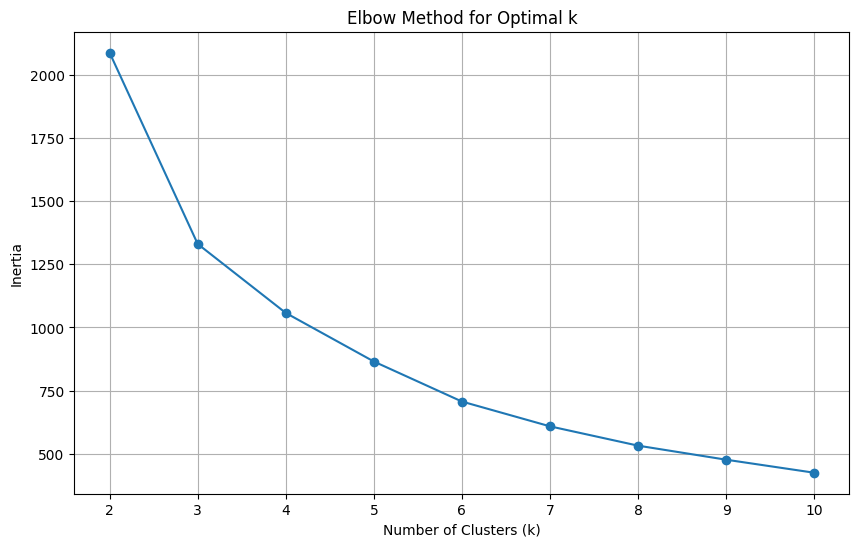

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# We use the 'scaled_features' from the previous step
print("\n--- Step 2: Running Elbow Method to find optimal k ---")

# Check if scaled_features exists
if 'scaled_features' not in locals():
    print("Error: 'scaled_features' not found. Please re-run Step 1 first.")
else:
    inertia = {}
    K_range = range(2, 11) # Test k from 2 to 10

    for k in K_range:
        kmeans_model = KMeans(
            n_clusters=k,
            init='k-means++', # Standard initialization method
            n_init=10,       # Run 10 times with different seeds and pick the best one
            random_state=42  # For reproducible results
        )
        kmeans_model.fit(scaled_features)
        inertia[k] = kmeans_model.inertia_
        print(f"  For k={k}, Inertia = {kmeans_model.inertia_}")

    # --- Plot the Elbow Curve ---
    print("\nPlotting Elbow Curve...")

    plt.figure(figsize=(10, 6))
    plt.plot(list(inertia.keys()), list(inertia.values()), 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.xticks(K_range)
    plt.grid(True)
    plt.savefig('elbow_plot.png')
    print("Elbow plot saved as elbow_plot.png. Please check the image.")

Excellent. The elbow plot is perfect.

**Analysis of the Elbow Plot**
Based on your plot, we can determine the optimal 'k':

   1. **From k=2 to k=3:** The inertia drops sharply, from ~2087 to ~1330. This is a massive improvement, meaning going from 2 to 3 clusters explains a lot more of the variance.

   2. **From k=3 to k=4:** The inertia drops from ~1330 to ~1057. This is still a good drop, but it's much less steep than the first one.

   3. **After k=4:** The line starts to flatten out significantly. The drop from 4 to 5, 5 to 6, etc., is much smaller, showing diminishing returns.

The most distinct "elbow"—the point where the graph bends most sharply—is at k=3. This suggests that 3 is the most efficient number of clusters for this dataset.



## Step 3: Run Final K-Means & Analyze

**What We Are Doing:** Now that we've chosen our optimal 'k' (k=3), we will run the KMeans algorithm one last time. This time, we will save the model and use it to assign a cluster label (0, 1, or 2) to each of our 1,561 "active accounts."

**How It Works:** We will run KMeans with n_clusters=3. The algorithm will find the 3 best "centers" for our scaled data. It will then assign each account to the nearest center. We will take these assignments (the "labels") and add them as a new column to our active_accounts_df.

**What to Expect in the Output:** You will see a printout of the first few rows of your active_accounts_df, now with a new cluster column at the end. This is the "Finding" from your proposal—the final grouped accounts.

In [38]:
import polars as pl

# We assume 'scaled_features' (numpy array) and
# 'active_accounts_df' (Polars DataFrame) are still in memory.

# Check if variables exist
if 'scaled_features' not in locals() or 'active_accounts_df' not in locals():
    print("Error: 'scaled_features' or 'active_accounts_df' not found.")
    print("Please re-run the previous steps to ensure variables are in memory.")
else:
    print("--- Step 3: Running Final Clustering with k=3 ---")

    # --- 1. Run Final K-Means Model ---
    FINAL_K = 3
    kmeans_final = KMeans(
        n_clusters=FINAL_K,
        init='k-means++',
        n_init=10,
        random_state=42
    )
    kmeans_final.fit(scaled_features)

    # Get the cluster labels for each account
    cluster_labels = kmeans_final.labels_

    print(f"Clustering complete. Found {len(np.unique(cluster_labels))} clusters.")

    # --- 2. Add Labels back to the DataFrame ---
    # Add the labels as a new column to our 'active_accounts_df'

    # Check if the number of labels matches the DataFrame length
    if len(cluster_labels) == len(active_accounts_df):
        account_features_clustered = active_accounts_df.with_columns(
            pl.Series("cluster", cluster_labels)
        )

        print("\n--- Final Clustered Account Features (first 10 rows) ---")
        print(account_features_clustered.head(10))

        print("\n--- Summary of Cluster Sizes ---")
        print(account_features_clustered['cluster'].value_counts(sort=True))

    else:
        print(f"Error: Length mismatch! Labels: {len(cluster_labels)}, DataFrame rows: {len(active_accounts_df)}")

--- Step 3: Running Final Clustering with k=3 ---
Clustering complete. Found 3 clusters.

--- Final Clustered Account Features (first 10 rows) ---
shape: (10, 6)
┌──────────────────┬──────────────────┬──────────────────┬─────────────┬─────────────────┬─────────┐
│ account.id       ┆ hour_of_day_mean ┆ is_weekend_ratio ┆ total_posts ┆ hourly_structs  ┆ cluster │
│ ---              ┆ ---              ┆ ---              ┆ ---         ┆ ---             ┆ ---     │
│ i64              ┆ f64              ┆ f64              ┆ u32         ┆ list[struct[2]] ┆ i32     │
╞══════════════════╪══════════════════╪══════════════════╪═════════════╪═════════════════╪═════════╡
│ 1093553670634435 ┆ 16.333333        ┆ 0.333333         ┆ 6           ┆ [{14,2},        ┆ 1       │
│ 35               ┆                  ┆                  ┆             ┆ {20,2}, …       ┆         │
│                  ┆                  ┆                  ┆             ┆ {18,1}]         ┆         │
│ 1134790571717012 ┆ 14.875   

In [39]:
import plotly.express as px
import polars as pl

# We assume 'account_features_clustered' is in memory from the previous step
print("--- Step 4 (Modified): Visualizing Clusters in Notebook ---")

if 'account_features_clustered' not in locals():
    print("Error: 'account_features_clustered' not found. Please re-run Step 3 first.")
else:
    try:
        # --- 1. Prepare DataFrame for Plotting ---
        # Convert cluster label to string so Plotly treats it as a category (distinct colors)
        plot_df = account_features_clustered.with_columns(
            pl.col('cluster').cast(pl.String).alias('cluster_label')
        )

        # --- 2. Create the 2D Scatter Plot ---
        print("Generating 2D cluster scatter plot...")

        fig = px.scatter(
            plot_df.to_pandas(),  # Plotly express works well with Pandas
            x="hour_of_day_mean",
            y="is_weekend_ratio",
            color="cluster_label",  # Color the dots based on their assigned cluster
            title="Temporal Clustering of Accounts by Posting Habits",
            labels={
                "hour_of_day_mean": "Mean Posting Hour (0-23)",
                "is_weekend_ratio": "Ratio of Posts on Weekends (0.0 - 1.0)",
                "cluster_label": "Discovered Cluster"
            },
            # Add hover data to see info for specific accounts
            hover_data=["account.id", "total_posts"]
        )

        fig.update_layout(xaxis=dict(range=[-1, 24]), yaxis=dict(range=[-0.1, 1.1]))

        # This command displays the plot in the notebook without needing kaleido
        fig.show()
        print("Plot displayed successfully in the notebook.")

    except Exception as e:
        print(f"An error occurred during visualization: {e}")

--- Step 4 (Modified): Visualizing Clusters in Notebook ---
Generating 2D cluster scatter plot...


Plot displayed successfully in the notebook.


### Cluster 2 (Red/Orange): "The Weekday-Only Operators"
- **Size:** 813 accounts (This is the largest group)

- **Behavioral Signature (The "Why"):**

    - **X-axis (Hour):** Their hour_of_day_mean is in the afternoon and evening (approx. 12:00 PM to 10:00 PM).

    - **Y-axis (Weekend):** Their is_weekend_ratio is extremely low (0.0 to ~0.3). Many accounts in this cluster have a ratio of 0.0, meaning they never post on a Saturday or Sunday.

- **Interpretation (CIB Relevance):** This is your most suspicious cluster and a classic signal of coordinated inauthentic behavior. A human user's activity would be spread across weekdays and weekends. A large group of accounts that only posts Monday-Friday suggests automation or a paid "9-to-5" operation. They are "on the clock" and "off" for the weekend. This is a very strong, non-human pattern.

### Cluster 1 (Purple): "The Early-Morning / Overnight Crew"
- **Size:** 477 accounts

- **Behavioral Signature (The "Why"):**

     - **X-axis (Hour):** Their hour_of_day_mean is low (approx. 2:00 AM to 10:00 AM). The cluster is centered around the very early morning.

     - **Y-axis (Weekend):** Their weekend activity is varied (0.0 to 1.0). This means the "weekend" feature wasn't what defined them; their "early hour" was the key trait.

- **Interpretation (CIB Relevance):** This cluster is also highly suspicious. Legitimate human activity is typically lowest between 2:00 AM and 5:00 AM. A large group of accounts that is most active during these "off-hours" strongly suggests automation. This could be a botnet scheduled to post when platform moderation is at its lightest, or it could be operated from a different time zone to target a US-based audience as they wake up.

### Cluster 0 (Green/Teal): "The 'Normal' Daytime & Weekend Users"
- **Size:** 271 accounts (This is the smallest group)

- **Behavioral Signature (The "Why"):**

    - **X-axis (Hour):** Their hour_of_day_mean is in the "normal" daytime (approx. 8:00 AM to 6:00 PM).

    - **Y-axis (Weekend):** Their is_weekend_ratio is high (mostly 0.3 to 1.0).

- **Interpretation (CIB Relevance):** This is our "baseline" or "control group." Their behavior is the most human-like: they post during the day, and their activity includes weekends, which aligns with typical human social media use. The fact that this is the smallest group in your dataset is, by itself, a very interesting finding.

## Ticket #11: Validate Cluster Personas with Activity Vectors.

What We Are Doing
As we discussed, we'll now create the 24-hour "fingerprint" plots to confirm or deny our personas. To properly test your "Weekday-Only Operators" hypothesis (Cluster 2), we will create two separate fingerprints for each cluster:

An Average Weekday activity plot

An Average Weekend activity plot

How It Works
The script will:

Add a day_of_week and is_weekend column to your main df_with_dates dataframe.

Join this information with your account_features_clustered table to get the cluster label for every single post.

Group all 16,000+ posts by cluster, is_weekend, and hour_of_day, then count them.

Normalize these counts by the total posts in that cluster to get a "frequency" percentage.

Plot these frequencies on a line chart.

In [40]:
import plotly.express as px
import polars as pl

print("--- Ticket #11 (Corrected): Validating Cluster Personas with Activity Vectors ---")

try:
    # --- 1. Get Day Type for Every Post ---
    # We assume 'df_with_dates' is in memory from the feature engineering step
    if 'df_with_dates' not in locals():
        raise ValueError("DataFrame 'df_with_dates' not found. Please re-run the Feature Engineering cell.")

    posts_with_day_type = df_with_dates.with_columns(
        pl.col('post_timestamp').dt.hour().alias('hour_of_day'),  # <-- THIS IS THE FIX
        pl.col('post_timestamp').dt.weekday().alias('day_of_week') # Mon=1, Sun=7
    ).with_columns(
        pl.when(pl.col('day_of_week') >= 6) # 6=Sat, 7=Sun
          .then(pl.lit("Weekend"))
          .otherwise(pl.lit("Weekday"))
          .alias('day_type')
    ).select(["account.id", "post_timestamp", "day_type", "hour_of_day"])

    # --- 2. Join Posts with their Cluster ID ---
    # We assume 'account_features_clustered' is in memory
    if 'account_features_clustered' not in locals():
        raise ValueError("DataFrame 'account_features_clustered' not found. Please re-run Step 3.")

    # Get just the account-to-cluster mapping
    cluster_map = account_features_clustered.select(["account.id", "cluster"])

    # Join this map with our full list of posts
    posts_with_cluster = posts_with_day_type.join(cluster_map, on="account.id")

    print("Joined post data with cluster labels.")

    # --- 3. Calculate Average Hourly Activity ---

    # a) Count total posts in each cluster *per day type* (for normalization)
    cluster_day_totals = posts_with_cluster.group_by(["cluster", "day_type"]).agg(
        pl.len().alias("total_posts_in_group")
    )

    # b) Count posts by cluster, day_type, and hour
    hourly_counts_by_cluster = (
        posts_with_cluster
        .group_by(["cluster", "day_type", "hour_of_day"])
        .agg(pl.len().alias("count_in_hour"))
    )

    # c) Join totals back and normalize
    # This calculates (total posts at 2pm on Weekdays) / (total posts on Weekdays)
    cluster_profiles = (
        hourly_counts_by_cluster
        .join(cluster_day_totals, on=["cluster", "day_type"])
        .with_columns(
            (pl.col("count_in_hour") / pl.col("total_posts_in_group")).alias("activity_frequency")
        )
        .sort(["cluster", "day_type", "hour_of_day"])
    )

    print("Calculated average hourly fingerprints for Weekday/Weekend.")
    print(cluster_profiles.head())

    # --- 4. Visualize the Fingerprints ---
    plot_df = cluster_profiles.to_pandas()

    # Ensure cluster is categorical for coloring
    plot_df['cluster'] = plot_df['cluster'].astype(str)

    fig = px.line(
        plot_df,
        x="hour_of_day",
        y="activity_frequency",
        color="cluster",        # Color by cluster
        line_dash="day_type",   # Use different line styles for Weekday/Weekend
        title="Average 24-Hour Activity Fingerprint (Weekday vs. Weekend)",
        labels={
            "hour_of_day": "Hour of Day (0-23)",
            "activity_frequency": "Avg. % of Activity in Day Type",
            "cluster": "Cluster ID",
            "day_type": "Day Type"
        },
        markers=True
    )

    fig.update_xaxes(dtick=1) # Show every hour
    fig.show()
    print("Plot displayed successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

--- Ticket #11 (Corrected): Validating Cluster Personas with Activity Vectors ---
Joined post data with cluster labels.
Calculated average hourly fingerprints for Weekday/Weekend.
shape: (5, 6)
┌─────────┬──────────┬─────────────┬───────────────┬──────────────────────┬────────────────────┐
│ cluster ┆ day_type ┆ hour_of_day ┆ count_in_hour ┆ total_posts_in_group ┆ activity_frequency │
│ ---     ┆ ---      ┆ ---         ┆ ---           ┆ ---                  ┆ ---                │
│ i32     ┆ str      ┆ i8          ┆ u32           ┆ u32                  ┆ f64                │
╞═════════╪══════════╪═════════════╪═══════════════╪══════════════════════╪════════════════════╡
│ 0       ┆ Weekday  ┆ 0           ┆ 573           ┆ 6194                 ┆ 0.092509           │
│ 0       ┆ Weekday  ┆ 1           ┆ 556           ┆ 6194                 ┆ 0.089764           │
│ 0       ┆ Weekday  ┆ 2           ┆ 488           ┆ 6194                 ┆ 0.078786           │
│ 0       ┆ Weekday  ┆ 3      

Plot displayed successfully.


--- Ticket #13: Engineering 24-D Activity Vectors ---
Created 24-D feature set with shape: (1561, 24)
Scaling 24-D features using StandardScaler...
Scaling complete. Data is ready for 24-D clustering.

--- Ticket #14: Running Elbow Method to find optimal k (24-D) ---
  For k=2, Inertia = 35758.50502694536
  For k=3, Inertia = 34237.863479773274
  For k=4, Inertia = 32970.56518007306
  For k=5, Inertia = 31926.999187133784
  For k=6, Inertia = 30850.549130047766
  For k=7, Inertia = 29905.501487714933
  For k=8, Inertia = 28937.33984967523
  For k=9, Inertia = 28049.027761800593
  For k=10, Inertia = 27276.64366299219

Plotting 24-D Elbow Curve...
Elbow plot saved as elbow_plot_24d.png. Please check the image.


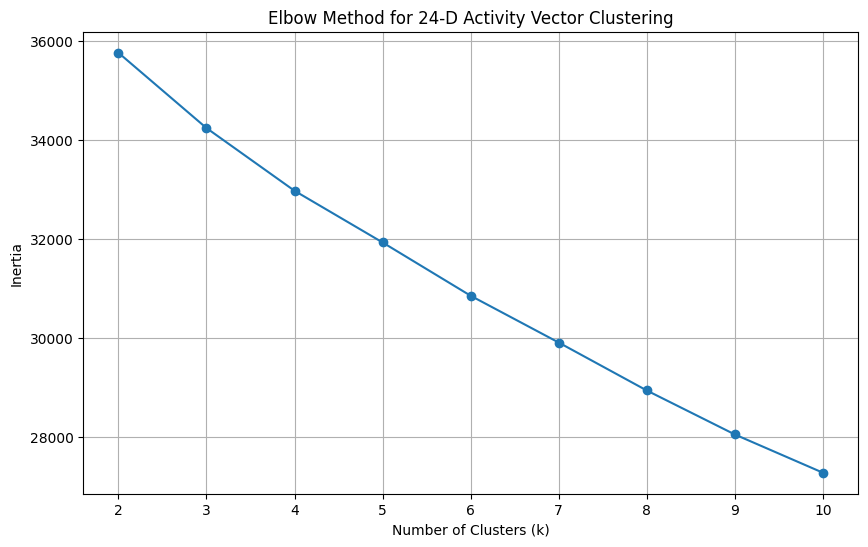

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import polars as pl
import numpy as np

print("--- Ticket #13: Engineering 24-D Activity Vectors ---")

try:
    # We assume 'account_features_clustered' is in memory
    if 'account_features_clustered' not in locals():
        raise ValueError("DataFrame 'account_features_clustered' not found. Please re-run Step 3.")

    # --- 1. Create Dense 24-Hour Vectors ---

    # Create a list to hold our new 24-D feature data
    activity_vectors_list = []

    # Get the total_posts and hourly_structs columns
    # Iterating is necessary to build the dense vectors
    for account_id, total_posts, structs in account_features_clustered.select(
        ["account.id", "total_posts", "hourly_structs"]
    ).rows():

        # Initialize a vector of 24 zeros
        vector = np.zeros(24)

        if structs: # Check if structs is not None
            for struct in structs:
                hour = struct['hour_of_day']
                count = struct['count_in_hour']
                if 0 <= hour < 24: # Safety check
                    vector[hour] = count

        # --- 2. Normalize (Frequency) ---
        # Divide by total_posts to get frequency.
        # Use np.nan_to_num to handle divide-by-zero if total_posts is 0 (though we filtered)
        normalized_vector = np.nan_to_num(vector / total_posts)
        activity_vectors_list.append(normalized_vector)

    # Convert our list of vectors into a Numpy array for sklearn
    features_24d = np.array(activity_vectors_list)

    print(f"Created 24-D feature set with shape: {features_24d.shape}")

    # --- 3. Scale the 24-D Features ---
    print("Scaling 24-D features using StandardScaler...")
    scaler_24d = StandardScaler()
    scaled_features_24d = scaler_24d.fit_transform(features_24d)

    print("Scaling complete. Data is ready for 24-D clustering.")

    # --- Ticket #14: Running Elbow Method on 24-D Data ---
    print("\n--- Ticket #14: Running Elbow Method to find optimal k (24-D) ---")

    inertia_24d = {}
    K_range = range(2, 11) # Test k from 2 to 10

    for k in K_range:
        kmeans_model_24d = KMeans(
            n_clusters=k,
            init='k-means++',
            n_init=10,
            random_state=42
        )
        kmeans_model_24d.fit(scaled_features_24d)
        inertia_24d[k] = kmeans_model_24d.inertia_
        print(f"  For k={k}, Inertia = {kmeans_model_24d.inertia_}")

    # --- Plot the New Elbow Curve ---
    print("\nPlotting 24-D Elbow Curve...")

    plt.figure(figsize=(10, 6))
    plt.plot(list(inertia_24d.keys()), list(inertia_24d.values()), 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for 24-D Activity Vector Clustering')
    plt.xticks(K_range)
    plt.grid(True)
    plt.savefig('elbow_plot_24d.png')
    print("Elbow plot saved as elbow_plot_24d.png. Please check the image.")

except Exception as e:
    print(f"An error occurred: {e}")

In [42]:
import plotly.express as px
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

print("--- Ticket #15 (Final Correction): Running 24-D Clustering & Visualizing ---")

try:
    # --- 1. Re-create 24-D Feature Set (to be safe) ---
    if 'account_features_clustered' not in locals():
        raise ValueError("DataFrame 'account_features_clustered' not found. Please re-run Step 3.")

    activity_vectors_list = []
    for account_id, total_posts, structs in account_features_clustered.select(
        ["account.id", "total_posts", "hourly_structs"]
    ).rows():
        vector = np.zeros(24)
        if structs:
            for struct in structs:
                hour = struct['hour_of_day']
                count = struct['count_in_hour']
                if 0 <= hour < 24:
                    vector[hour] = count

        normalized_vector = np.nan_to_num(vector / total_posts)
        activity_vectors_list.append(normalized_vector)

    features_24d_normalized = np.array(activity_vectors_list)

    # --- 2. Scale the features ---
    scaler_24d = StandardScaler()
    scaled_features_24d = scaler_24d.fit_transform(features_24d_normalized)
    print(f"Created and scaled 24-D feature set with shape: {scaled_features_24d.shape}")

    # --- 3. Run Final 24-D K-Means Model ---
    FINAL_K_24D = 4

    kmeans_final_24d = KMeans(
        n_clusters=FINAL_K_24D,
        init='k-means++',
        n_init=10,
        random_state=42
    )
    kmeans_final_24d.fit(scaled_features_24d)
    cluster_labels_24d = kmeans_final_24d.labels_
    print(f"Clustering complete. Found {len(np.unique(cluster_labels_24d))} new clusters.")

    # --- 4. Add New Labels and Vectors to DataFrame ---
    vector_series = pl.Series("activity_vector_24d", features_24d_normalized.tolist())
    label_series = pl.Series("cluster_24d", cluster_labels_24d)

    final_clustered_df = account_features_clustered.with_columns(
        vector_series,
        label_series
    )

    print("\n--- Summary of New 24-D Cluster Sizes ---")
    print(final_clustered_df['cluster_24d'].value_counts(sort=True))

    # --- 5. Calculate Average Fingerprints (THE FIX) ---
    print("\nCalculating average fingerprints for new 24-D clusters...")

    plot_data = []
    avg_vectors_for_debug = []

    for cluster_id in range(FINAL_K_24D):
        cluster_df = final_clustered_df.filter(pl.col("cluster_24d") == cluster_id)
        cluster_vectors_np = np.array(cluster_df["activity_vector_24d"].to_list())
        avg_vector = np.mean(cluster_vectors_np, axis=0)
        avg_vectors_for_debug.append({"cluster": cluster_id, "avg_vector": avg_vector})

        for hour, frequency in enumerate(avg_vector):
            plot_data.append({
                "cluster_24d": str(cluster_id),
                "hour_of_day": hour,
                "activity_frequency": frequency
            })

    print("Average fingerprints calculated successfully:")
    for item in avg_vectors_for_debug:
        print(f"Cluster {item['cluster']}: {np.round(item['avg_vector'], 4)}")

    # --- 6. Visualize the New 24-D Fingerprints (THE FIX) ---
    plot_df = pd.DataFrame(plot_data)

    # *** THIS IS THE FIX ***
    # Sort the DataFrame so Plotly connects the dots in the right order
    plot_df = plot_df.sort_values(by=["cluster_24d", "hour_of_day"])
    # **********************

    print("\nGenerating 24-D cluster fingerprint plot...")

    fig = px.line(
        plot_df,
        x="hour_of_day",
        y="activity_frequency",
        color="cluster_24d",
        title="Average 24-Hour Fingerprint (4-Cluster 24-D Model)",
        labels={
            "hour_of_day": "Hour of Day (0-23)",
            "activity_frequency": "Avg. % of Daily Activity",
            "cluster_24d": "New Cluster ID"
        },
        markers=True
    )

    fig.update_xaxes(dtick=1)
    fig.show()
    print("Plot displayed successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

--- Ticket #15 (Final Correction): Running 24-D Clustering & Visualizing ---
Created and scaled 24-D feature set with shape: (1561, 24)
Clustering complete. Found 4 new clusters.

--- Summary of New 24-D Cluster Sizes ---
shape: (4, 2)
┌─────────────┬───────┐
│ cluster_24d ┆ count │
│ ---         ┆ ---   │
│ i32         ┆ u32   │
╞═════════════╪═══════╡
│ 2           ┆ 731   │
│ 3           ┆ 438   │
│ 0           ┆ 243   │
│ 1           ┆ 149   │
└─────────────┴───────┘

Calculating average fingerprints for new 24-D clusters...
Average fingerprints calculated successfully:
Cluster 0: [0.0611 0.0629 0.1187 0.1297 0.1231 0.0873 0.0577 0.0381 0.0073 0.0051
 0.0031 0.0058 0.0149 0.0161 0.0169 0.0286 0.0273 0.0142 0.0306 0.0272
 0.0307 0.0347 0.0307 0.0281]
Cluster 1: [0.0456 0.0244 0.0171 0.0206 0.0113 0.0088 0.0163 0.017  0.0527 0.0588
 0.1066 0.1573 0.1436 0.032  0.024  0.0316 0.0288 0.0221 0.0294 0.0266
 0.0346 0.0345 0.025  0.0311]
Cluster 2: [0.071  0.0635 0.0417 0.0218 0.0137 0.0074

Plot displayed successfully.


In [43]:
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import os
from pathlib import Path
import datetime

print("--- Full Analysis Run (Polars Version) ---")
print("This script will run all steps from loading to final validation.")

try:
    # --- 1. FIND AND LOAD DATA ---
    data_filename = 'sampledata_truthsocial.csv'
    repo_name = 'cib-mango-tree-peter'

    # Using YOUR file-finding function from the notebook
    def find_data_file(data_filename, max_parent_levels=10):
        cwd = Path.cwd()
        tried = []
        # 1) Check cwd and its parents for data/<filename>
        for p in [cwd] + list(cwd.parents)[:max_parent_levels]:
            candidate = p / 'data' / data_filename
            tried.append(str(candidate))
            if candidate.exists():
                print(f"Found data file at {candidate} (from cwd parents)")
                return str(candidate)

        # 2) Look for repo_name in common drive roots (fast) and search under it
        for drive_letter in ['D:', 'C:', 'E:']:
            drive_root = Path(drive_letter + os.sep)
            if drive_root.exists():
                candidate_repo = drive_root / 'GitHub' / repo_name
                tried.append(str(candidate_repo))
                if candidate_repo.exists():
                    try:
                        matches = list(candidate_repo.rglob(data_filename))
                        if matches:
                            print(f"Found data file under repo path {candidate_repo}")
                            return str(matches[0])
                    except Exception:
                        pass

        # 3) Try to detect repo root by scanning cwd parents for .git/src/reports
        for p in [cwd] + list(cwd.parents)[:max_parent_levels]:
            if (p / '.git').exists() or (p / 'src').exists() or (p / 'reports').exists():
                repo_root = p
                tried.append(str(repo_root))
                try:
                    matches = list(repo_root.rglob(data_filename))
                    if matches:
                        print(f"Found data file under detected repo root {repo_root}")
                        return str(matches[0])
                except Exception:
                    pass

        # 4) Last resort (from your code)
        drive_root = Path(cwd.anchor)
        tried.append(str(drive_root))
        try:
            matches = list(drive_root.rglob(data_filename))
            if matches:
                print(f"Found data file via drive-wide search under {drive_root}")
                return str(matches[0])
        except Exception as e:
            print(f"Drive-wide search failed: {e}")

        return None # Return None if nothing is found

    data_file_path = find_data_file(data_filename)

    if data_file_path is None:
         # Fallback path if your function can't find it
        data_file_path = 'sampledata_truthsocial.csv'
        if not os.path.exists(data_file_path):
            raise FileNotFoundError(f"Error: Could not find '{data_file_path}'")

    print(f"Loading data from: {data_file_path}")
    df = pl.read_csv(data_file_path)

    # --- 2. WEEK 3 FEATURE ENGINEERING (2D Features) ---
    print("Running Week 3 Feature Engineering...")
    df_with_dates = df.with_columns(
        pl.col('created_at').str.to_datetime(format="%Y-%m-%dT%H:%M:%S%.f%:z").alias('post_timestamp')
    )
    features_df = df_with_dates.with_columns(
        pl.col('post_timestamp').dt.hour().alias('hour_of_day'),
        pl.col('post_timestamp').dt.weekday().alias('day_of_week') # Mon=1, Sun=7
    ).with_columns(
        pl.when(pl.col('day_of_week') >= 6).then(1).otherwise(0).alias('is_weekend') # 6=Sat, 7=Sun
    )
    account_features = features_df.group_by("account.id").agg(
        pl.col('hour_of_day').mean().alias('hour_of_day_mean'),
        pl.col('is_weekend').mean().alias('is_weekend_ratio'),
        pl.len().alias('total_posts')
    )
    hourly_counts = features_df.group_by(["account.id", "hour_of_day"]).agg(
        pl.len().alias('count_in_hour')
    )
    activity_vectors = hourly_counts.group_by("account.id").agg(
        pl.struct(["hour_of_day", "count_in_hour"]).alias("hourly_structs")
    )
    account_features = account_features.join(activity_vectors, on="account.id")
    print("Feature engineering complete.")

    # --- 3. 2D CLUSTERING (k=3) ---
    print("Running 2D Clustering (k=3)...")
    MIN_POSTS = 5
    active_accounts_df = account_features.filter(pl.col('total_posts') >= MIN_POSTS)
    features_to_cluster = active_accounts_df.select('hour_of_day_mean', 'is_weekend_ratio')
    features_numpy = features_to_cluster.to_numpy()

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_numpy)

    kmeans_final = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
    kmeans_final.fit(scaled_features)
    cluster_labels = kmeans_final.labels_

    account_features_clustered = active_accounts_df.with_columns(
        pl.Series("cluster", cluster_labels)
    )
    print(f"2D clustering complete. Found 3 clusters for {len(account_features_clustered)} accounts.")

    # --- 4. TICKET #13 (24D FEATURES): NORMALIZE & SCALE ---
    print("Running Ticket #13 (Engineering 24-D Vectors)...")

    activity_vectors_list = []
    for account_id, total_posts, structs in account_features_clustered.select(
        ["account.id", "total_posts", "hourly_structs"]
    ).rows():
        vector = np.zeros(24)
        if structs: # Check if structs is not None and not empty
            for struct in structs:
                hour = struct['hour_of_day']
                count = struct['count_in_hour']
                if 0 <= hour < 24:
                    vector[hour] = count

        normalized_vector = np.nan_to_num(vector / total_posts)
        activity_vectors_list.append(normalized_vector)

    features_24d_normalized = np.array(activity_vectors_list)

    scaler_24d = StandardScaler()
    scaled_features_24d = scaler_24d.fit_transform(features_24d_normalized)
    print(f"Created and scaled 24-D feature set with shape: {scaled_features_24d.shape}")

    # --- 5. TICKET #15 (24D CLUSTERING): RUN K-MEANS (k=4) ---
    print("Running Ticket #15 (Final 24-D Clustering)...")
    FINAL_K_24D = 4
    kmeans_final_24d = KMeans(n_clusters=FINAL_K_24D, init='k-means++', n_init=10, random_state=42)
    kmeans_final_24d.fit(scaled_features_24d)
    cluster_labels_24d = kmeans_final_24d.labels_

    # Add new labels and vectors to the final DataFrame
    vector_series = pl.Series("activity_vector_24d", features_24d_normalized.tolist())
    label_series = pl.Series("cluster_24d", cluster_labels_24d)

    final_clustered_df = account_features_clustered.with_columns(
        vector_series,
        label_series
    )
    print("24-D clustering complete.")

    # --- 6. FINAL VALIDATION (USER REQUEST) ---
    print("\n--- Final Validation: Cross-Analyzing 2D and 24D Clusters ---")

    # a. Cross-Tabulation
    print("\n--- Cross-Tabulation: Original (2D) vs. New (24D) Clusters ---")
    cross_tab = (
        final_clustered_df
        .group_by(["cluster", "cluster_24d"])
        .agg(pl.len().alias("count"))
        .sort(["cluster", "cluster_24d"])
    )
    print(cross_tab)

    # b. Calculate Avg. Weekend Ratio for New 24-D Clusters
    print("\n--- Average Weekend Ratio for New 24-D Clusters ---")
    weekend_ratio_by_cluster = (
        final_clustered_df
        .group_by("cluster_24d")
        .agg(
            pl.col("is_weekend_ratio").mean().alias("avg_weekend_ratio"),
            pl.len().alias("count")
        )
        .sort("cluster_24d")
    )
    print(weekend_ratio_by_cluster)

    # c. Visualize the Weekend Ratios
    print("\nGenerating bar chart for average weekend ratios...")
    # Convert to pandas for Plotly
    plot_df = weekend_ratio_by_cluster.to_pandas()
    plot_df['cluster_24d'] = plot_df['cluster_24d'].astype(str)

    fig = px.bar(
        plot_df,
        x="cluster_24d",
        y="avg_weekend_ratio",
        color="cluster_24d",
        title="Average Weekend Ratio by New 24-D Cluster",
        labels={
            "cluster_24d": "New Cluster ID (from 24-D Model)",
            "avg_weekend_ratio": "Average % of Posts on Weekends (0.0 - 1.0)"
        }
    )
    fig.update_yaxes(range=[0, 1.0]) # Set Y-axis from 0% to 100%
    fig.show()
    print("Plot displayed successfully.")

except ImportError:
    print("\n--- ERROR ---")
    print("Critical library not found. Please install 'polars', 'sklearn', 'plotly', and 'pandas'.")
    print("You can install them by running:")
    print("pip install polars scikit-learn plotly pandas")
except FileNotFoundError as e:
    print(f"File loading error: {e}")
    print("Please make sure 'sampledata_truthsocial.csv' is in the correct directory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Full Analysis Run (Polars Version) ---
This script will run all steps from loading to final validation.
Found data file at D:\GitHub\cib-mango-tree-peter\data\sampledata_truthsocial.csv (from cwd parents)
Loading data from: D:\GitHub\cib-mango-tree-peter\data\sampledata_truthsocial.csv
Running Week 3 Feature Engineering...
Feature engineering complete.
Running 2D Clustering (k=3)...
2D clustering complete. Found 3 clusters for 1561 accounts.
Running Ticket #13 (Engineering 24-D Vectors)...
Created and scaled 24-D feature set with shape: (1561, 24)
Running Ticket #15 (Final 24-D Clustering)...
24-D clustering complete.

--- Final Validation: Cross-Analyzing 2D and 24D Clusters ---

--- Cross-Tabulation: Original (2D) vs. New (24D) Clusters ---
shape: (12, 3)
┌─────────┬─────────────┬───────┐
│ cluster ┆ cluster_24d ┆ count │
│ ---     ┆ ---         ┆ ---   │
│ i32     ┆ i32         ┆ u32   │
╞═════════╪═════════════╪═══════╡
│ 0       ┆ 0           ┆ 28    │
│ 0       ┆ 1           

Plot displayed successfully.
